In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import joblib
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [6]:
data = pd.read_csv('new_data.csv', index_col = 0)

## FASTTEXT

In [7]:
import re
def find_hangul(text):
    return re.findall(r'[ㄱ-ㅎ가-힣]+',text)
lidata = data[data['summarize_'].notnull()]['summarize_'].map(find_hangul)

In [8]:
def only_hangul(text):
    return ' '.join(re.findall(r'[ㄱ-ㅎ가-힣]+',text))
lidata2 = data[data['summarize_'].notnull()]['summarize_'].map(only_hangul)

In [9]:
from gensim.models.fasttext import FastText

In [10]:
model = FastText(size=100, sg=1, window =5, min_count=3)

In [11]:
model.build_vocab(sentences = lidata)

In [12]:
model.train(sentences = lidata, epochs = 20, total_examples= model.corpus_count, 
            total_words= model.corpus_total_words)

In [13]:
model.wv.vocab

{'오늘': <gensim.models.keyedvectors.Vocab at 0x1e2f9e0b288>,
 '합니다': <gensim.models.keyedvectors.Vocab at 0x1e2f9e0b608>,
 '타인의': <gensim.models.keyedvectors.Vocab at 0x1e2f9e0b088>,
 '어린': <gensim.models.keyedvectors.Vocab at 0x1e2f9e0b2c8>,
 '학생들을': <gensim.models.keyedvectors.Vocab at 0x1e2f9e0b708>,
 '지옥으로': <gensim.models.keyedvectors.Vocab at 0x1e2f9e0b788>,
 '몰아넣은': <gensim.models.keyedvectors.Vocab at 0x1e2f9e0b7c8>,
 '가해자를': <gensim.models.keyedvectors.Vocab at 0x1e2f9e0b808>,
 '포토라인에': <gensim.models.keyedvectors.Vocab at 0x1e2f9e0b6c8>,
 '세워주세요': <gensim.models.keyedvectors.Vocab at 0x1e2f9e0b748>,
 '절대로': <gensim.models.keyedvectors.Vocab at 0x1e2f9e0b848>,
 '마스크로': <gensim.models.keyedvectors.Vocab at 0x1e2f9e0b888>,
 '얼굴을': <gensim.models.keyedvectors.Vocab at 0x1e2f9e0b8c8>,
 '가리지': <gensim.models.keyedvectors.Vocab at 0x1e2f9e0b908>,
 '말아주십시오': <gensim.models.keyedvectors.Vocab at 0x1e2f9e0b948>,
 '만명에': <gensim.models.keyedvectors.Vocab at 0x1e2f9e0b988>,
 '만원이나': <gens

In [14]:
from sklearn.model_selection import train_test_split
doc_train, doc_test, y_train, y_test = train_test_split(data['summarize_'], data['sentiment'], test_size = 0.2 , random_state =42)

In [15]:
import numpy as np

In [16]:
doc_train.shape

(8000,)

In [17]:
X_train = np.zeros((8000,100))

for i, doc in enumerate(doc_train.iloc[0:7999]):
    try:
        vs = [model.wv[word]for word in find_hangul(doc)] 
    except:
        vs = None
    if vs:
        X_train[i,] = np.mean(vs, axis=0)

In [18]:
X_test = np.zeros((2000,100))

for i, doc in enumerate(doc_test.iloc[0:1999]):
    try:
        vs = [model.wv[word]for word in find_hangul(doc)] 
    except:
        vs = None
    if vs:
        X_test[i,] = np.mean(vs, axis=0)

In [19]:
import tensorflow as tf

In [50]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1024, activation='relu', input_shape=(100,)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [51]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 1024)              103424    
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dense_32 (Dense)             (None, 128)              

In [41]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [28]:
history = model.fit(X_train, y_train.values, epochs = 100, validation_data = (X_test,y_test.values), callbacks = [tf.keras.callbacks.EarlyStopping()])

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 3s 331us/sample - loss: 0.6197 - accuracy: 0.6625 - val_loss: 0.6319 - val_accuracy: 0.6515
Epoch 2/100
8000/8000 [==============================] - 2s 258us/sample - loss: 0.6023 - accuracy: 0.6793 - val_loss: 0.6112 - val_accuracy: 0.6695
Epoch 3/100
8000/8000 [==============================] - 2s 252us/sample - loss: 0.5760 - accuracy: 0.6981 - val_loss: 0.5588 - val_accuracy: 0.7055
Epoch 4/100
8000/8000 [==============================] - 2s 249us/sample - loss: 0.5705 - accuracy: 0.7088 - val_loss: 0.6146 - val_accuracy: 0.6770


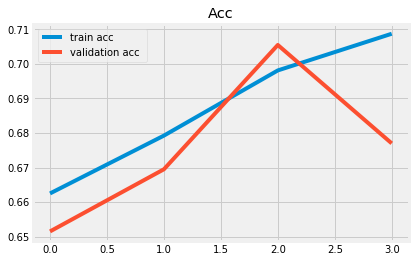

In [29]:
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="validation acc ")
plt.legend()
plt.title("Acc")
plt.show()

In [30]:
model.evaluate(X_test, y_test)

2000/2000 [==============================] - 0s 75us/sample - loss: 0.6146 - accuracy: 0.6770


[0.6146353623867035, 0.677]

## LSTM

In [32]:
data['summarize_'] = data['summarize_'].astype('str')

In [34]:
import joblib
tk = joblib.load('tokenizer.pkl')

In [81]:
seqs = tk.texts_to_sequences(data['summarize_'])

In [82]:
pads = tf.keras.preprocessing.sequence.pad_sequences(seqs, maxlen=None, padding='pre', truncating='pre')

In [83]:
X_train, X_test, y_train, y_test = train_test_split(pads, data['sentiment'], test_size=0.2, random_state=42)


In [84]:
NUM_WORDS= tk.num_words + 1

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUM_WORDS, 8, mask_zero=True),
    tf.keras.layers.LSTM(8),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [85]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 8)           16008     
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 9         
Total params: 16,561
Trainable params: 16,561
Non-trainable params: 0
_________________________________________________________________


In [86]:
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [87]:
history = model.fit(X_train, y_train.values, epochs=10, batch_size=512, validation_data =(X_test,y_test))

Epoch 1/10
16/16 [==============================] - 117s 7s/step - loss: 0.6933 - accuracy: 0.4919 - val_loss: 0.6927 - val_accuracy: 0.5150
Epoch 2/10
16/16 [==============================] - 115s 7s/step - loss: 0.6921 - accuracy: 0.5490 - val_loss: 0.6917 - val_accuracy: 0.5695
Epoch 3/10
16/16 [==============================] - 117s 7s/step - loss: 0.6905 - accuracy: 0.5957 - val_loss: 0.6898 - val_accuracy: 0.5795
Epoch 4/10
16/16 [==============================] - 117s 7s/step - loss: 0.6874 - accuracy: 0.6211 - val_loss: 0.6856 - val_accuracy: 0.6015
Epoch 5/10
16/16 [==============================] - 115s 7s/step - loss: 0.6803 - accuracy: 0.6386 - val_loss: 0.6750 - val_accuracy: 0.6300
Epoch 6/10
16/16 [==============================] - 115s 7s/step - loss: 0.6543 - accuracy: 0.6683 - val_loss: 0.6297 - val_accuracy: 0.6805
Epoch 7/10
16/16 [==============================] - 114s 7s/step - loss: 0.6211 - accuracy: 0.6831 - val_loss: 0.6105 - val_accuracy: 0.7000
Epoch 8/10
16

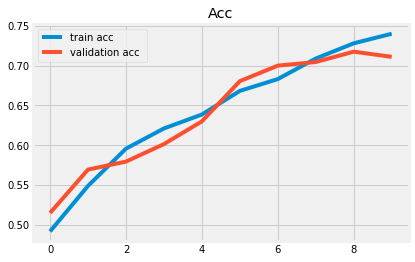

In [88]:
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="validation acc ")
plt.legend()
plt.title("Acc")
plt.show()

In [89]:
model.evaluate(X_test, y_test)

63/63 [==============================] - 33s 528ms/step - loss: 0.5877 - accuracy: 0.7110


[0.5876666307449341, 0.7110000252723694]

#  전이학습

In [36]:
e = np.load('word-emb.npz')['emb']

In [38]:
NUM_WORDS= tk.num_words + 1

emb2  = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim = tk.num_words +1,
                              output_dim=8,
                              embeddings_initializer= tf.keras.initializers.Constant(e))
])


model = tf.keras.Sequential([
    emb2,
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [39]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, None, 8)           16008     
_________________________________________________________________
dense_15 (Dense)             (None, None, 512)         4608      
_________________________________________________________________
global_average_pooling1d_1 ( (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                

In [93]:
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [94]:
history = model.fit(X_train, y_train.values, epochs=50, batch_size=512, validation_data =(X_test,y_test), callbacks = [tf.keras.callbacks.EarlyStopping()])

Epoch 1/50
16/16 [==============================] - 1s 82ms/step - loss: 0.6893 - accuracy: 0.5390 - val_loss: 0.6875 - val_accuracy: 0.6460
Epoch 2/50
16/16 [==============================] - 1s 76ms/step - loss: 0.6877 - accuracy: 0.6528 - val_loss: 0.6865 - val_accuracy: 0.6720
Epoch 3/50
16/16 [==============================] - 1s 77ms/step - loss: 0.6867 - accuracy: 0.6381 - val_loss: 0.6854 - val_accuracy: 0.6725
Epoch 4/50
16/16 [==============================] - 1s 76ms/step - loss: 0.6856 - accuracy: 0.6536 - val_loss: 0.6841 - val_accuracy: 0.6740
Epoch 5/50
16/16 [==============================] - 1s 76ms/step - loss: 0.6844 - accuracy: 0.6560 - val_loss: 0.6829 - val_accuracy: 0.6715
Epoch 6/50
16/16 [==============================] - 1s 77ms/step - loss: 0.6832 - accuracy: 0.6547 - val_loss: 0.6815 - val_accuracy: 0.6715
Epoch 7/50
16/16 [==============================] - 1s 78ms/step - loss: 0.6819 - accuracy: 0.6561 - val_loss: 0.6801 - val_accuracy: 0.6725
Epoch 8/50
16

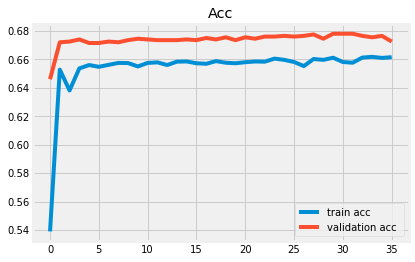

In [95]:
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="validation acc ")
plt.legend()
plt.title("Acc")
plt.show()

In [96]:
model.evaluate(X_test, y_test)

63/63 [==============================] - 0s 3ms/step - loss: 0.6368 - accuracy: 0.6725


[0.6368385553359985, 0.6725000143051147]

# conv1d

In [97]:
model =tf.keras.Sequential([
    tf.keras.layers.Embedding(NUM_WORDS, 8, input_length = 3718),
    tf.keras.layers.Conv1D(3, 3),
    tf.keras.layers.MaxPool1D(5),
    tf.keras.layers.Conv1D(3, 3),
    tf.keras.layers.MaxPool1D(5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [98]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 3718, 8)           16008     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3716, 3)           75        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 743, 3)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 741, 3)            30        
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 148, 3)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 444)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                

In [99]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [130]:
history = model.fit(X_train, y_train, epochs=50, batch_size=512, validation_data =(X_test,y_test), callbacks = [tf.keras.callbacks.EarlyStopping()])

Epoch 1/50
16/16 [==============================] - 1s 86ms/step - loss: 0.5971 - accuracy: 0.6718 - val_loss: 0.5971 - val_accuracy: 0.6850
Epoch 2/50
16/16 [==============================] - 1s 88ms/step - loss: 0.5933 - accuracy: 0.6779 - val_loss: 0.5890 - val_accuracy: 0.6865
Epoch 3/50
16/16 [==============================] - 1s 90ms/step - loss: 0.5888 - accuracy: 0.6802 - val_loss: 0.5848 - val_accuracy: 0.6885
Epoch 4/50
16/16 [==============================] - 1s 90ms/step - loss: 0.5805 - accuracy: 0.6836 - val_loss: 0.5798 - val_accuracy: 0.6905
Epoch 5/50
16/16 [==============================] - 1s 90ms/step - loss: 0.5703 - accuracy: 0.6873 - val_loss: 0.5740 - val_accuracy: 0.6925
Epoch 6/50
16/16 [==============================] - 1s 91ms/step - loss: 0.5617 - accuracy: 0.6955 - val_loss: 0.5687 - val_accuracy: 0.6980
Epoch 7/50
16/16 [==============================] - 1s 86ms/step - loss: 0.5521 - accuracy: 0.7079 - val_loss: 0.5629 - val_accuracy: 0.7065
Epoch 8/50
16

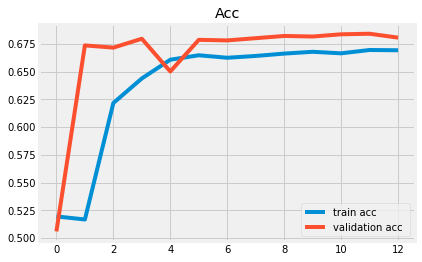

In [101]:
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="validation acc ")
plt.legend()
plt.title("Acc")
plt.show()

In [102]:
model.evaluate(X_test, y_test)

63/63 [==============================] - 0s 4ms/step - loss: 0.6032 - accuracy: 0.6805


[0.6031667590141296, 0.6804999709129333]

In [106]:
# conv1d에 대해서  hyper opt 진행

In [105]:
!pip install hyperopt

In [107]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

In [126]:

space = hp.choice('model', [
    {
        'lr': hp.loguniform('lr2', -8, 2),
        'filters': hp.choice('filters',[2,3,4,5]),
        'kernel_size': hp.choice('kernel_size',[2,3,4,5]),
        'pooling': hp.choice('pooling',[2,3,4,5,6])
    }
])

In [127]:
sample(space)

{'filters': 2, 'kernel_size': 2, 'lr': 0.5819839069027372, 'pooling': 6}

In [131]:
from hyperopt import STATUS_OK
import uuid


def objective(h):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(NUM_WORDS, 8, input_length = 3718)),
    model.add(tf.keras.layers.Conv1D(filters = h['filters'], kernel_size = h['kernel_size'],activation='relu'))
    model.add(tf.keras.layers.MaxPool1D(pool_size = h['pooling']))
    model.add(tf.keras.layers.Conv1D(filters = h['filters'], kernel_size = h['kernel_size'],activation='relu'))
    model.add(tf.keras.layers.MaxPool1D(pool_size = h['pooling']))
    model.add(tf.keras.layers.Flatten()),
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(h['lr']),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    
    model.fit(
        X_train,
        y_train, 
        epochs=20, 
        validation_data = (X_test, y_test), 
        verbose=2, 
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy')])

    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    
    filename = str(uuid.uuid4()) 
    model.save(filename)
    
    return {
        'loss': -acc,
        'status': STATUS_OK,
        'filename': filename
     }

In [132]:
import warnings
warnings.simplefilter('ignore')

tf.get_logger().setLevel('ERROR')
h = sample(space)
objective(h)

Epoch 1/20
250/250 - 2s - loss: 0.6773 - accuracy: 0.5990 - val_loss: 0.6356 - val_accuracy: 0.6775
Epoch 2/20
250/250 - 2s - loss: 0.6159 - accuracy: 0.6672 - val_loss: 0.6031 - val_accuracy: 0.6850
Epoch 3/20
250/250 - 2s - loss: 0.5902 - accuracy: 0.6849 - val_loss: 0.5864 - val_accuracy: 0.6915
Epoch 4/20
250/250 - 2s - loss: 0.5654 - accuracy: 0.7053 - val_loss: 0.5708 - val_accuracy: 0.7010
Epoch 5/20
250/250 - 2s - loss: 0.5419 - accuracy: 0.7291 - val_loss: 0.5602 - val_accuracy: 0.7070
Epoch 6/20
250/250 - 2s - loss: 0.5193 - accuracy: 0.7435 - val_loss: 0.5605 - val_accuracy: 0.7030


{'filename': 'fc64ee1b-39cb-41b9-817d-b38f1e905049',
 'loss': -0.703000009059906,
 'status': 'ok'}

In [137]:
from hyperopt import fmin, rand, tpe, Trials
trials = Trials()
best = fmin(
    objective,
    space=space,
    algo=tpe.suggest,
    max_evals=10,
    trials=trials)

Epoch 1/20
250/250 - 2s - loss: 0.6319 - accuracy: 0.6518 - val_loss: 0.5761 - val_accuracy: 0.7070

Epoch 2/20
250/250 - 2s - loss: 0.5500 - accuracy: 0.7269 - val_loss: 0.5721 - val_accuracy: 0.6880

Epoch 1/20
250/250 - 2s - loss: 0.6301 - accuracy: 0.6436 - val_loss: 0.5869 - val_accuracy: 0.6735

Epoch 2/20
250/250 - 2s - loss: 0.5605 - accuracy: 0.7138 - val_loss: 0.5642 - val_accuracy: 0.6975

Epoch 3/20
250/250 - 2s - loss: 0.5249 - accuracy: 0.7409 - val_loss: 2.4356 - val_accuracy: 0.5060

Epoch 1/20
250/250 - 2s - loss: 8554.2676 - accuracy: 0.5020 - val_loss: 0.9914 - val_accuracy: 0.4940

Epoch 2/20
250/250 - 2s - loss: 0.7467 - accuracy: 0.5005 - val_loss: 0.7295 - val_accuracy: 0.4940

Epoch 1/20
250/250 - 2s - loss: 0.7786 - accuracy: 0.4984 - val_loss: 0.6931 - val_accuracy: 0.5060

Epoch 2/20
250/250 - 2s - loss: 0.6989 - accuracy: 0.5027 - val_loss: 0.6932 - val_accuracy: 0.5060

Epoch 1/20
250/250 - 2s - loss: 0.6933 - accuracy: 0.5023 - val_loss: 0.6931 - val_accur

In [138]:
trials.best_trial

{'book_time': datetime.datetime(2020, 6, 25, 13, 47, 11, 952000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'filters': [5],
   'kernel_size': [5],
   'lr2': [5],
   'model': [5],
   'pooling': [5]},
  'tid': 5,
  'vals': {'filters': [2],
   'kernel_size': [1],
   'lr2': [0.001012386716306271],
   'model': [0],
   'pooling': [3]},
  'workdir': None},
 'owner': None,
 'refresh_time': datetime.datetime(2020, 6, 25, 13, 47, 27, 393000),
 'result': {'filename': 'f837acd0-0d61-4b76-8d1b-3479f26052d4',
  'loss': -0.7020000219345093,
  'status': 'ok'},
 'spec': None,
 'state': 2,
 'tid': 5,
 'version': 0}

In [139]:
best_model = tf.keras.models.load_model(trials.best_trial['result']['filename'])

In [140]:
# hyper opt를 통해 최적화된 모델을 통해 test 진행

In [171]:
test_data = pd.read_csv('/gdrive/My Drive/data.csv', index_col = 0).iloc[5000:-20000,:]

In [193]:
test_data['sentiment'] = test_data['청원수'].map(lambda x: 1 if x> 1000 else 0)

In [172]:
from gensim.summarization.summarizer import summarize
def summarizee(x):
    summ_plot = ''
    try:
        if summarize(x,word_count=100) != '':
            summ_plot = summarize(x,word_count=100)
        else:
            summ_plot = x
            
    except:
        summ_plot = x
        
    return summ_plot
test_data['summarize_'] = test_data['내용'].map(lambda x: summarizee(x) )

In [181]:
test_data['summarize_'] = test_data['summarize_'].astype('str')

In [186]:
seqs = tk.texts_to_sequences(test_data['summarize_'])
pads_test = tf.keras.preprocessing.sequence.pad_sequences(seqs, maxlen=3718, padding='pre', truncating='pre')

In [195]:
from sklearn.metrics import accuracy_score
pred = best_model.predict_classes(pads_test)

accuracy_score(pred, test_data['sentiment'])

0.5221489161168709

In [199]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
confusion_matrix(test_data['sentiment'], pred)

array([[2301, 2261],
       [1288, 1577]])

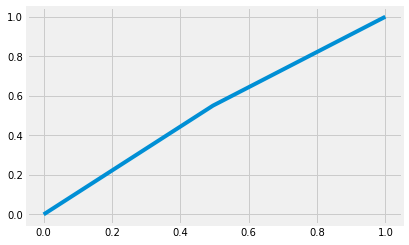

In [200]:
fpr, tpr, threshold = roc_curve(test_data['sentiment'],pred)
plt.plot(fpr,tpr)